# Лабораторная работа №4 "Реализация приложения по распознаванию номеров домов"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets

import numpy as np
import matplotlib.pyplot as plt
import random

import h5py
import cv2
import json
import pathlib
from PIL import Image

### Задание 1.
Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST).
Ознакомьтесь с имеющимися работами по данной тематике: англоязычная статья (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf), видео на YouTube (https://www.youtube.com/watch?v=vGPI_JvLoN0).


Загружаем данные

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

print(f"X_train shape - {x_train.shape}")
print(f"y_train shape - {y_train.shape}")

print(f"X_test shape - {x_test.shape}")
print(f"y_test shape - {y_test.shape}")

11493376/11490434 [==============================] - 0s 0us/step
X_train shape - (60000, 28, 28)
y_train shape - (60000,)
X_test shape - (10000, 28, 28)
y_test shape - (10000,)


In [ ]:
def show_images(x, y, h=3, w=10):
    fig, ax = plt.subplots(h, w, figsize=(15, 5))

    cur = 0
    step = len(y) // (h * w)

    for i in range(h):
        for j in range(w):
            img = x[cur]
            ax[i, j].imshow(img, cmap='gray')
            cur += step

    plt.show()

In [5]:
show_images(x_train, y_train)

Теперь сгенерируем синтетические данные, соединив рандомные цифры в последовательности цифр до 5 элементов

In [ ]:
def generate_synthetic_data(x, y, output_size=None, max_numbers_size=5):
    if output_size is None:
        output_size = len(x)

    img_len, img_height, img_width = x.shape
    img_size = img_width * img_height
    synt_x_train, synt_y_train = [], []
    for _ in range(output_size):
        numbers_size = np.random.randint(1, max_numbers_size + 1)
        offset = np.random.randint(0, max_numbers_size - numbers_size + 1)
        digit = np.zeros((img_height, img_width * max_numbers_size))
        labels = [10] * max_numbers_size
        for i in range(offset, offset + numbers_size):
            ind = random.randint(0, img_len - 1)
            rand_digit = x[ind]
            digit[:, i * img_width: i * img_width + img_width] = rand_digit
            labels[i] = y[ind]
        synt_x_train.append(digit)
        synt_y_train.append(labels)
    
    return np.array(synt_x_train), np.array(synt_y_train)

In [ ]:
synt_x_train, synt_y_train = generate_synthetic_data(x_train, y_train)

In [19]:
fig, ax = plt.subplots(3, 5, figsize=(20, 5))

cur = 0
step = 1

for i in range(3):
    for j in range(5):
        img = synt_x_train[cur]
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_title(" ".join([str(i) for i in synt_y_train[cur]]))
        cur += step

plt.show()

Далее построим модель описанную в этой статье: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf

*Our best architecture consists of eight convolutional hidden layers, one locally connected hidden
layer, and two densely connected hidden layers. All connections are feedforward and go from one
layer to the next (no skip connections). The first hidden layer contains maxout units (Goodfellow
et al., 2013) (with three filters per unit) while the others contain rectifier units (Jarrett et al., 2009;
Glorot et al., 2011). The number of units at each spatial location in each layer is [48, 64, 128,
160] for the first four layers and 192 for all other locally connected layers. The fully connected
layers contain 3,072 units each. Each convolutional layer includes max pooling and subtractive
normalization. The max pooling window size is 2 × 2. The stride alternates between 2 and 1 at each
layer, so that half of the layers don’t reduce the spatial size of the representation. All convolutions
use zero padding on the input to preserve representation size. The subtractive normalization operates
on 3x3 windows and preserves representation size. All convolution kernels were of size 5 × 5. We
trained with dropout applied to all hidden layers but not the input.*

In [ ]:
class Model:
    MAX_NUMBERS_SIZE = 5
    BATCH_SIZE = 128
    EPOCHS = 30

    def __init__(self, input_shape=(28, 28 * 5, 1), dropout_rate=0.5, n_class=11):
        self.input_shape = input_shape
        self.dropout_rate = dropout_rate
        self.n_class = n_class
        self.history = None
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = keras.Input((self.input_shape))
    
        x = layers.BatchNormalization()(inputs)
        x = layers.Conv2D(48, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate/4)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate/4)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate/2)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(160, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate/2)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(192, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(192, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dense(1024, activation='relu')(x)

        o1 = layers.Dense(self.n_class, activation='softmax')(x)
        o2 = layers.Dense(self.n_class, activation='softmax')(x)
        o3 = layers.Dense(self.n_class, activation='softmax')(x)
        o4 = layers.Dense(self.n_class, activation='softmax')(x)
        o5 = layers.Dense(self.n_class, activation='softmax')(x)

        output = [o1, o2, o3, o4, o5]

        return keras.Model(inputs=inputs, outputs=output)
    
    def get_instance(self):
        return self.model

    def compile(self, *args, **kwargs):
        return self.model.compile(*args, **kwargs)
    
    def fit(self, x, y, **kwargs):
        kwargs.setdefault('batch_size', self.BATCH_SIZE)
        kwargs.setdefault('epochs', self.EPOCHS)
        x = self.prepare_x_dimension(x)
        y = self.prepare_y_dimension(y)
        self.history = self.model.fit(x, y, **kwargs)
    
    def evaluate(self, x, y, **kwargs):
        kwargs.setdefault('verbose', 2)
        x = self.prepare_x_dimension(x)
        y = self.prepare_y_dimension(y)
        return self.model.evaluate(x, y, **kwargs)
    
    def predict(self, x):
        x = x.reshape((1, *x.shape, 1))
        prediction = self.model.predict(x)
        elem_prediction = [np.argmax(prediction[i]) for i in range(len(prediction))]
        return [str(i) if i != 10 else '.' for i in elem_prediction]

    def prepare_x_dimension(self, x):
        return x.reshape((*x.shape, 1))

    def prepare_y_dimension(self, y):
        return [y.T[i] for i in range(self.MAX_NUMBERS_SIZE)]

In [22]:
model = Model()
model.get_instance().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 140, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 28, 140, 1)   4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 140, 48)  1200        batch_normalization_6[0][0]      
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 14, 70, 48)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 128

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(synt_x_train, synt_y_train, batch_size=BATCH_SIZE, epochs=5, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 77s 182ms/step - loss: 2.8334 - dense_9_loss: 0.4868 - dense_10_loss: 0.6085 - dense_11_loss: 0.6364 - dense_12_loss: 0.6021 - dense_13_loss: 0.4996 - dense_9_accuracy: 0.8295 - dense_10_accuracy: 0.7796 - dense_11_accuracy: 0.7666 - dense_12_accuracy: 0.7807 - dense_13_accuracy: 0.8290 - val_loss: 21.2576 - val_dense_9_loss: 3.2923 - val_dense_10_loss: 4.5316 - val_dense_11_loss: 3.2221 - val_dense_12_loss: 3.3849 - val_dense_13_loss: 6.8267 - val_dense_9_accuracy: 0.4367 - val_dense_10_accuracy: 0.6262 - val_dense_11_accuracy: 0.6987 - val_dense_12_accuracy: 0.6177 - val_dense_13_accuracy: 0.4102
Epoch 2/5
422/422 [==============================] - 75s 177ms/step - loss: 0.2409 - dense_9_loss: 0.0409 - dense_10_loss: 0.0505 - dense_11_loss: 0.0543 - dense_12_loss: 0.0491 - dense_13_loss: 0.0461 - dense_9_accuracy: 0.9890 - dense_10_accuracy: 0.9864 - dense_11_accuracy: 0.9853 - dense_12_accuracy: 0.9870 - dense_13_accuracy: 0.9878 

In [ ]:
synt_x_test, synt_y_test = generate_synthetic_data(x_test, y_test)

In [25]:
model.evaluate(synt_x_test, synt_y_test)

313/313 - 7s - loss: 0.1602 - dense_9_loss: 0.0366 - dense_10_loss: 0.0338 - dense_11_loss: 0.0288 - dense_12_loss: 0.0264 - dense_13_loss: 0.0346 - dense_9_accuracy: 0.9949 - dense_10_accuracy: 0.9945 - dense_11_accuracy: 0.9947 - dense_12_accuracy: 0.9954 - dense_13_accuracy: 0.9953


[0.16019763052463531,
 0.036592286080121994,
 0.03384922444820404,
 0.02884196862578392,
 0.026351287961006165,
 0.034562841057777405,
 0.9948999881744385,
 0.9944999814033508,
 0.994700014591217,
 0.9954000115394592,
 0.9952999949455261]

Prediction: 7 1 7 1 4


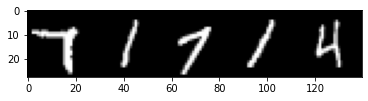

In [28]:
test_elem = random.choice(synt_x_test)
prediction = model.predict(test_elem)
print(f"Prediction: {' '.join(prediction)}")
plt.imshow(test_elem, cmap='gray')
plt.show()

Как видим, модель получилась достаточно точной. Это связано с тем, что для такой архитектуры модели количетсво данных оказалось достаточным, а также данные приблизительно однородные.

### Задание 2.
После уточнения модели на синтетических данных попробуйте обучить ее на реальных данных (набор Google Street View). Что изменилось в модели?

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!wget http://ufldl.stanford.edu/housenumbers/test.tar.gz
!tar xvfz train.tar.gz
!tar xvfz test.tar.gz
!rm -rf train.tar.gz
!rm -rf test.tar.gz
!ls

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_dir = pathlib.Path('/content/train/')
test_dir = pathlib.Path('/content/test/')

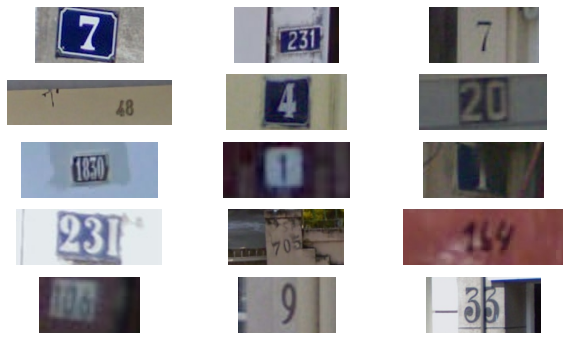

In [127]:
f = plt.figure(figsize=(10, 6))

for i, fn in enumerate(np.random.choice(list(train_dir.glob('*.png')), 15)):
    f.add_subplot(5, 3, i + 1)
    plt.imshow(Image.open(fn, mode='r'))
    plt.axis('off')

plt.show()

Как видим, изображения разного размера. Для того чтобы обучить на них модель нам необходимо для начала привести их к одному размеру.

In [ ]:
DRIVE_DIR = '/content/drive/My Drive/'
drive_train_dir = pathlib.Path(f'{DRIVE_DIR}train')
drive_test_dir = pathlib.Path(f'{DRIVE_DIR}test')
drive_train_dir.mkdir(exist_ok=True)
drive_test_dir.mkdir(exist_ok=True)

In [ ]:
def get_data_structure(filepath):
    stored_struct_fn = filepath.split('/')[0] + '/struct.json'
    stored_struct_fullpath = f'{DRIVE_DIR}{filepath}'

    if pathlib.Path(stored_struct_fullpath).is_file():
        with open(stored_struct_fullpath) as file:
            data = json.load(file)
        return data

    f = h5py.File(filepath, 'r')

    data = {
        'label': [],
        'height': [],
        'width': [],
        'left': [],
        'top': [],
    }
    
    def add_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        data[name].append(vals)
    
    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(add_attrs)

    with open(stored_struct_fullpath, 'w') as file:
        json.dump(data, file)

    return data

In [ ]:
train_struct = get_data_structure('train/digitStruct.mat')
test_struct = get_data_structure('test/digitStruct.mat')

In [ ]:
def crop_image(filepath, struct, crop_size=(64, 64)):
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, *_ = img.shape
    filename = filepath.split('/')[-1].split('.')[0]

    img_index = int(filename) - 1
    left = np.min(struct['left'][img_index])
    top = np.min(struct['top'][img_index])
    bottom = (np.max(struct['top'][img_index]) + np.max(struct['height'][img_index]))
    right = (np.max(struct['left'][img_index]) + np.max(struct['width'][img_index]))

    box_width = right - left
    box_height = bottom - top
    left = np.max((0, int(left - box_width * 0.1))).astype(np.uint)
    right = np.min((img_width, int(right + box_width * 0.1))).astype(np.uint)
    bottom = np.min((img_height, int(bottom + box_height * 0.1))).astype(np.uint)
    top = np.max((0, int(top - box_height * 0.1))).astype(np.uint)

    cropped = img[top:bottom, left:right, :].copy()
    rescaled = cv2.resize(cropped, crop_size)
    return rescaled

In [132]:
f = plt.figure(figsize=(10, 8))
i = 0

for fn in np.random.choice(list(train_dir.glob('*.png')), 5):
    f.add_subplot(5, 2, i + 1)
    plt.imshow(Image.open(fn, mode='r'))
    plt.axis('off')

    f.add_subplot(5, 2, i + 2)
    plt.imshow(crop_image(str(fn), train_struct))
    plt.axis('off')
    i +=2

plt.show()

In [ ]:
def save_cropped_dataset(data_dir, data_struct, folder):
    result_dir = pathlib.Path(f'/content/drive/My Drive/{folder}/')
    result_dir.mkdir(parents=True, exist_ok=True)

    for fn in list(data_dir.glob('*.png')):
        array = crop_image(str(fn), data_struct)
        image = keras.preprocessing.image.array_to_img(array)
        image.save(f'{str(result_dir)}/{fn.name}')
    print(f'Saved to {str(result_dir.name)}')

In [31]:
save_cropped_dataset(train_dir, train_struct, folder='train')
save_cropped_dataset(test_dir, test_struct, folder='test')

Saved to train
Saved to test


In [ ]:
def load_dataset(folder, data_struct, max_numbers_size=5):
    # data_dir = pathlib.Path(f'/content/drive/My Drive/{folder}/')
    data_dir = pathlib.Path(f'/content/{folder}/')

    X, y = [], []
    for fn in list(data_dir.glob('*.png')):
        image_ind = int(fn.name.split('.')[0])
        try:
            labels = data_struct['label'][image_ind - 1]
            labels_len = len(labels)
        except Exception:
            continue
    
        if labels_len > max_numbers_size:
            continue
        
        labels = [int(l) for l in labels]
        labels = [l if l != 10 else 0 for l in labels]
        labels.extend([10] * (max_numbers_size - labels_len))
        labels.insert(0, labels_len)

        image = crop_image(str(fn), data_struct)
        array = image / 255
        # image = Image.open(str(fn), mode='r')
        # array = np.asarray(image) / 255
        X.append(array)
        y.append(labels)

    return np.array(X), np.array(y)

In [136]:
X_tr, y_tr = load_dataset('train', train_struct)
X_tr.shape

(33401, 64, 64, 3)

In [137]:
fig = plt.figure(figsize=(12, 10))
set_size = len(X_tr)

for i in range(1, 26):
    image_ind = random.randint(0, set_size - 1)
    img = X_tr[image_ind]
    label = y_tr[image_ind]
    ax = fig.add_subplot(5, 5, i)
    ax.set_title("".join([str(i) for i in label[1:] if i != 10]) + f", len = {label[0]}")
    ax.set_axis_off()
    plt.imshow(img)

Данные предобработанны. Теперь всё готово, чтобы построить модель, учитывающую длину числа.

In [ ]:
class RealNumbersModel:
    MAX_NUMBERS_SIZE = 5
    BATCH_SIZE = 128
    EPOCHS = 5

    def __init__(self, model=None, input_shape=(64, 64, 3), dropout_rate=0.5, n_class=11, n_len=MAX_NUMBERS_SIZE + 1):
        self.input_shape = input_shape
        self.dropout_rate = dropout_rate
        self.n_class = n_class
        self.n_len = n_len
        self.history = None
        if model is None:
            self.model = self._build_model()
        else:
            self.model = model
        
    def _build_model(self):
        inputs = keras.Input((self.input_shape))
    
        x = layers.BatchNormalization()(inputs)
        x = layers.Conv2D(48, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate/4)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate/4)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate/2)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(160, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate/2)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(192, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(192, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(192, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
        x = layers.Dropout(self.dropout_rate)(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(192, 5, activation='relu', padding='same', use_bias=False)(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
        x = layers.Dropout(self.dropout_rate)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(3072, activation='relu')(x)
        x = layers.Dense(3072, activation='relu')(x)

        l = layers.Dense(self.n_len, activation='softmax')(x)
        o1 = layers.Dense(self.n_class, activation='softmax')(x)
        o2 = layers.Dense(self.n_class, activation='softmax')(x)
        o3 = layers.Dense(self.n_class, activation='softmax')(x)
        o4 = layers.Dense(self.n_class, activation='softmax')(x)
        o5 = layers.Dense(self.n_class, activation='softmax')(x)

        output = [l, o1, o2, o3, o4, o5]
        return keras.Model(inputs=inputs, outputs=output)
    
    def get_instance(self):
        return self.model

    def compile(self, *args, **kwargs):
        return self.model.compile(*args, **kwargs)
    
    def fit(self, x, y, **kwargs):
        kwargs.setdefault('batch_size', self.BATCH_SIZE)
        kwargs.setdefault('epochs', self.EPOCHS)
        y = self.prepare_y_dimension(y)
        self.history = self.model.fit(x, y, **kwargs)
    
    def evaluate(self, x, y, **kwargs):
        kwargs.setdefault('batch_size', self.BATCH_SIZE)
        kwargs.setdefault('verbose', 2)
        y = self.prepare_y_dimension(y)
        return self.model.evaluate(x, y, **kwargs)
    
    def predict(self, x):
        prediction = self.model.predict(x)
        lengths = prediction[0]
        labels = np.array(prediction[1:]).swapaxes(0, 1)
        
        output = []
        for i in range(len(lengths)):
            digit_preds = labels[i]
            elem_pred = [np.argmax(digit_preds[j]) for j in range(self.MAX_NUMBERS_SIZE)]
            str_digit = "".join([str(i) for i in elem_pred if i != 10])
            output.append(str_digit)
        
        return output

    def prepare_y_dimension(self, y):
        return [y.T[i] for i in range(self.MAX_NUMBERS_SIZE + 1)]

In [5]:
model = RealNumbersModel()
model.get_instance().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 48)   3600        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 48)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [140]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_tr, y_tr, validation_split=0.2, epochs=30)

Epoch 1/30
209/209 [==============================] - 51s 245ms/step - loss: 7.1554 - dense_58_loss: 1.0747 - dense_59_loss: 2.1034 - dense_60_loss: 2.3526 - dense_61_loss: 1.3095 - dense_62_loss: 0.2934 - dense_63_loss: 0.0220 - dense_58_accuracy: 0.5727 - dense_59_accuracy: 0.2624 - dense_60_accuracy: 0.1753 - dense_61_accuracy: 0.6895 - dense_62_accuracy: 0.9535 - dense_63_accuracy: 0.9952 - val_loss: 7.6374 - val_dense_58_loss: 1.2254 - val_dense_59_loss: 2.0715 - val_dense_60_loss: 2.3135 - val_dense_61_loss: 1.5454 - val_dense_62_loss: 0.4608 - val_dense_63_loss: 0.0208 - val_dense_58_accuracy: 0.4691 - val_dense_59_accuracy: 0.2387 - val_dense_60_accuracy: 0.2033 - val_dense_61_accuracy: 0.5481 - val_dense_62_accuracy: 0.9579 - val_dense_63_accuracy: 0.9999
Epoch 2/30
209/209 [==============================] - 50s 239ms/step - loss: 5.6141 - dense_58_loss: 0.5004 - dense_59_loss: 1.9079 - dense_60_loss: 2.0299 - dense_61_loss: 0.9567 - dense_62_loss: 0.2153 - dense_63_loss: 0.00

In [141]:
X_ts, y_ts = load_dataset('test', test_struct)
X_ts.shape

(13068, 64, 64, 3)

In [142]:
model.evaluate(X_ts, y_ts)

103/103 - 7s - loss: 0.7350 - dense_58_loss: 0.0931 - dense_59_loss: 0.2383 - dense_60_loss: 0.2647 - dense_61_loss: 0.1154 - dense_62_loss: 0.0214 - dense_63_loss: 0.0021 - dense_58_accuracy: 0.9793 - dense_59_accuracy: 0.9443 - dense_60_accuracy: 0.9418 - dense_61_accuracy: 0.9760 - dense_62_accuracy: 0.9950 - dense_63_accuracy: 0.9998


[0.7349964380264282,
 0.09312379360198975,
 0.23827506601810455,
 0.2646706998348236,
 0.11538833379745483,
 0.02140210010111332,
 0.0021364863496273756,
 0.9792622923851013,
 0.9442914128303528,
 0.9418426752090454,
 0.9760483503341675,
 0.9950259923934937,
 0.9998469352722168]

In [ ]:
from sklearn.metrics import accuracy_score

def convert_true_labels(y):
    output = []
    for labels in y:
        int_labels = [int(i) for i in labels[1:]]
        str_labels = [str(i) for i in int_labels if i != 10]
        str_digit = "".join(str_labels)
        output.append(str_digit)

    return output

In [144]:
true_labels = convert_true_labels(y_ts)
predicted_labels = model.predict(X_ts)
score = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy score: {score}')

Accuracy score: 0.8885062748699112


Как видим, точность на тестовой выборке получилась ~88.9%, что достаточно неплохо.

Попробуем изобразить несколько случайных значений.

In [145]:
fig = plt.figure(figsize=(12, 10))
set_size = len(X_ts)

test_set = [random.choice(X_ts) for _ in range(15)]

preds = model.predict(np.array(test_set))
for i in range(1, 16):
    ax = fig.add_subplot(5, 3, i)
    ax.set_title(f'Predicted: {preds[i - 1]}')
    ax.set_axis_off()
    plt.imshow(test_set[i - 1])

plt.show()

Модель необходимо сохранить в файл, чтобы впоследствии её можно было использовать уже готовую.

In [ ]:
model.get_instance().save(f'{DRIVE_DIR}Colab Notebooks/4/nn_model.h5')

### Задание 3.
Сделайте множество снимков изображений номеров домов с помощью смартфона на ОС Android.

In [48]:
!ls /content/drive/'My Drive'/'Colab Notebooks/4/'

IMG_20200429_202928__01.jpg  new1.jpg		    P00429-203733__01.jpg
IMG_20200429_202952__01.jpg  nn_model.h5	    P00429-203749__01.jpg
IMG_20200429_203042__01.jpg  P00429-203344__01.jpg  P00429-203817__01.jpg
IMG_20200429_203329__01.jpg  P00429-203441__01.jpg  P00429-204626__01__01.jpg
IMG_20200429_203402__01.jpg  P00429-203524__01.jpg
IMG_20200429_203423__01.jpg  P00429-203556__01.jpg


In [43]:
X_real = []

data_dir = pathlib.Path(f'{DRIVE_DIR}Colab Notebooks/4/')

for fn in data_dir.glob('*.jpg'):

    img = cv2.imread(str(fn), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255
    X_real.append(img)
X_real = np.array(X_real)
X_real.shape

(15, 64, 64, 3)

### Задание 4.
Реализуйте приложение для ОС Android, которое может распознавать цифры в номерах домов, используя разработанный ранее классификатор. Какова доля правильных классификаций?


Для начала протестируем веса нейронной сети на реальных изображениях.

In [ ]:
new_model = keras.models.load_model(f'{DRIVE_DIR}Colab Notebooks/4/nn_model.h5')
nm = RealNumbersModel(model=new_model)

In [47]:
fig = plt.figure(figsize=(12, 10))

preds = nm.predict(X_real)
for i in range(1, 16):
    ax = fig.add_subplot(5, 3, i)
    ax.set_title(f'Predicted: {preds[i - 1]}')
    ax.set_axis_off()
    plt.imshow(X_real[i - 1])

plt.show()

Исходя из представленных результатов можно сказать, что нейронная сеть научилась довольно неплохо распознавать реальные номера домов. Из 15 картинок 5 были определены неправильно. Однако справедливости ради стоит заметить, что эти 5 картинок имеют наихудшее разрешение по сравнению с остальными.

Затем создадим телеграм бота, которому можно посылать изображения и получать в ответ предикшн. Чтобы поддерживать непрерывную работу бота, зедеплоим код на AWS сервер.

Исходный код бота находится в отдельном репозитории: https://bitbucket.org/ViktorPresniatski/multidigit-recognition-app

In [1]:
from IPython.display import Image

Image(filename='screenshot.jpg')